## Temperature forecast using Deep Learning Univariable LSTM Model

In [1]:
# Common imports
import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

DATA_PATH = "../data/"

reset_graph()

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
#warnings.filterwarnings("ignore", category=WARNING) 
print(sys.version)
print(tf.__version__)
print(tf.keras.__version__)
print(pd.__version__)

3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
1.13.1
2.2.4-tf
0.24.2


In [3]:
n_inputs = 1 # input temperature
n_lstm_neurons = 150 #neurons in rnn/lstm hidden layer
n_dense_neurons = 100
n_steps = 6 # features or time steps for time series for 6 hrs lag value to forcast
n_outputs = 1 # output temperature
n_layers = 5
batch_size = 360 # 36 cities, 10 hrs of each city
n_epochs = 5000 
n_learning_rate = 0.001
# initialize a list to store test results
test_ar = []

In [4]:
# read 'temp_dataset.csv'  dataset as a dataframe
temp_df = pd.read_csv(DATA_PATH + 'weather_temperature.csv', low_memory =  False)
# Convert index column to datetime dtype.
temp_df.datetime = pd.to_datetime(temp_df.datetime, infer_datetime_format = True)
temp_df.set_index('datetime', inplace = True)
print('temp_df ', temp_df.shape)
#print(temp_df.info(verbose = True, null_counts = True))

temp_df_Array = temp_df.values

Columns = temp_df.columns
city_cnt = 36
print(Columns)

temp_df  (44460, 36)
Index(['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles',
       'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver',
       'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis',
       'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta',
       'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh',
       'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston',
       'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya',
       'Jerusalem'],
      dtype='object')


In [5]:
## split a uni-variate sequence into samples
def split_sequences(ar, n_steps1):
    ts_length = ar.shape[0] - n_steps1 -1
    print('ts_length', ts_length)
    Ts = np.empty([ts_length * city_cnt, (n_steps1 + 1) ])
    
    print(ar.shape, Ts.shape)
    for i in range(ts_length):
        for k in range(city_cnt):
            Ts[i * city_cnt + k ] = ar.T[k][i: i + n_steps1+1] #Ts_Entry

    X = Ts[:, :-1]
    y = Ts[:, 1:]    
    return X, y

X, y = split_sequences(temp_df_Array, n_steps)
train_size =  X.shape[0] - batch_size - 48  #test_size * city_cnt
train_size = ((int)(train_size/batch_size)) * batch_size
print(train_size)
test_size = batch_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:train_size + test_size]
y_test = y[train_size:train_size + test_size]


# All data needs to be scaled to a small range like 0 to 1 for the neural
# network to work well. Create scalers for the inputs and outputs.
# Added 0.1 in min and max value to avoid divide by zero error

X_scaler = MinMaxScaler(feature_range=(0.1, 1.1))
y_scaler = MinMaxScaler(feature_range=(0.1, 1.1))

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

X_train_scaled = X_train_scaled.reshape(train_size, n_steps, n_inputs)
y_train_scaled = y_train_scaled.reshape(train_size, n_steps, n_inputs)
X_test_scaled = X_test_scaled.reshape(test_size, n_steps, n_inputs)
y_test_scaled = y_test_scaled.reshape(test_size, n_steps, n_inputs)
print('X_train ', X_train_scaled.shape, y_train_scaled.shape)
print('X_test ', X_test_scaled.shape, y_test_scaled.shape)

ts_length 44453
(44460, 36) (1600308, 7)
1599840
X_train  (1599840, 6, 1) (1599840, 6, 1)
X_test  (360, 6, 1) (360, 6, 1)


###### Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [6]:
# Univariate LSTM to forecast Temperature

# create model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(tf.keras.layers.LSTM(500, activation='relu', input_shape=(n_steps, n_inputs), return_sequences = True))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

# Add another:
model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences = True))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

# Add another:
model.add(tf.keras.layers.LSTM(300, activation='relu', return_sequences = True))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

# Add another:
model.add(tf.keras.layers.LSTM(400, activation='relu', return_sequences = True))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

# Add another:
model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences = True))
model.add(tf.layers.BatchNormalization())
model.add(tf.layers.Dropout(0.1))

model.add(tf.layers.Dense(1))

model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(n_learning_rate), metrics=['mse', 'mae', 'mape'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
strategy = tf.distribute.MirroredStrategy()
config = tf.estimator.RunConfig(train_distribute=strategy, save_checkpoints_steps = 1000)

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))
    dataset = dataset.shuffle(buffer_size = train_size)
    dataset = dataset.repeat(50)
    dataset = dataset.batch(batch_size, drop_remainder = True)
    return dataset

estimator = tf.keras.estimator.model_to_estimator(model, config=config, model_dir='univar_lstm_temperature_model1/')
estimator.train(input_fn=train_input_fn, steps=n_epochs)

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Configured nccl all-reduce.
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Using config: {'_task_type': 'worker', '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb8e057e2e8>, '_distribute_coordinator_mode': None, '_master': '', '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_num_worker_replicas': 1, '_evaluation_master': '', '_global_id_in_cluster

INFO:tensorflow:loss = 0.00040234835, step = 2900 (11.040 sec)
INFO:tensorflow:Saving checkpoints for 3000 into univar_lstm_temperature_model1/model.ckpt.
INFO:tensorflow:global_step/sec: 7.80031
INFO:tensorflow:loss = 0.00033060598, step = 3000 (12.820 sec)
INFO:tensorflow:global_step/sec: 9.06255
INFO:tensorflow:loss = 0.00030443264, step = 3100 (11.034 sec)
INFO:tensorflow:global_step/sec: 9.06052
INFO:tensorflow:loss = 0.0004254359, step = 3200 (11.037 sec)
INFO:tensorflow:global_step/sec: 9.06885
INFO:tensorflow:loss = 0.00033971062, step = 3300 (11.027 sec)
INFO:tensorflow:global_step/sec: 9.06347
INFO:tensorflow:loss = 0.0002619435, step = 3400 (11.033 sec)
INFO:tensorflow:global_step/sec: 9.04795
INFO:tensorflow:loss = 0.00032234954, step = 3500 (11.052 sec)
INFO:tensorflow:global_step/sec: 8.99465
INFO:tensorflow:loss = 0.00034594623, step = 3600 (11.117 sec)
INFO:tensorflow:global_step/sec: 9.05295
INFO:tensorflow:loss = 0.00035117025, step = 3700 (11.047 sec)
INFO:tensorflow

In [8]:
def test_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled))
    dataset = dataset.batch(batch_size, drop_remainder = True)
    print(dataset)
    return dataset

test_result = estimator.evaluate(input_fn=test_input_fn, steps = 1)

print("loss (test-set):", test_result)
    
y_pred = estimator.predict(input_fn=test_input_fn)
mape = test_result['mean_absolute_percentage_error']
mae = test_result['mean_absolute_error']
rmse = np.sqrt(test_result['mean_squared_error'])

print(y_pred)
test_ar.append({'label':'DL-Univar_Temperature_LSTM', 'mape' : mape, 'mae': mae,'rmse':rmse})    

<DatasetV1Adapter shapes: ((360, 6, 1), (360, 6, 1)), types: (tf.float64, tf.float64)>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21T06:43:17Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from univar_lstm_temperature_model1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-06-21-06:43:18
INFO:tensorflow:Saving dict for global step 5000: global_step = 5000, loss = 0.00024661515, mean_absolute_error = 0.010721802, mean_absolute_percentage_error = 1.6232684, mean_squared_error = 0.00024661515
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: univar_lstm_temperature_model1/model.ckpt-5000
loss (test-set): {'mean_absolute_error': 0.010721802, 'mean_absolute

In [9]:
print(test_ar)

[{'label': 'DL-Univar_Temperature_LSTM', 'mae': 0.010721802, 'mape': 1.6232684, 'rmse': 0.015703985}]


In [10]:
predict_scaled = list(y_pred)
print(len(predict_scaled))
predict_ar = np.array(predict_scaled)
#print(predict_ar)

<DatasetV1Adapter shapes: ((360, 6, 1), (360, 6, 1)), types: (tf.float64, tf.float64)>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from univar_lstm_temperature_model1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
360


In [11]:
print(predict_ar.shape)
y_pred_scaled = np.empty([predict_ar.shape[0], n_steps])
print(y_pred_scaled.shape)
for i in range(predict_ar.shape[0]):
    predict_val = list(predict_ar[i].values())
    #print(predict_val)
    y_pred_scaled[i] = predict_val[0].reshape(predict_val[0].shape[0])
print(y_pred_scaled.shape)
y_pred_scaled = y_pred_scaled.reshape(predict_ar.shape[0], n_steps, 1)
print(y_pred_scaled.shape)
print(y_test_scaled.shape)

(360,)
(360, 6)
(360, 6)
(360, 6, 1)
(360, 6, 1)


sequence_test  (36, 1, 10, 6)
(360, 6, 1) 360
(360, 6, 1)
(360, 6, 1)
(36, 1, 10, 6)


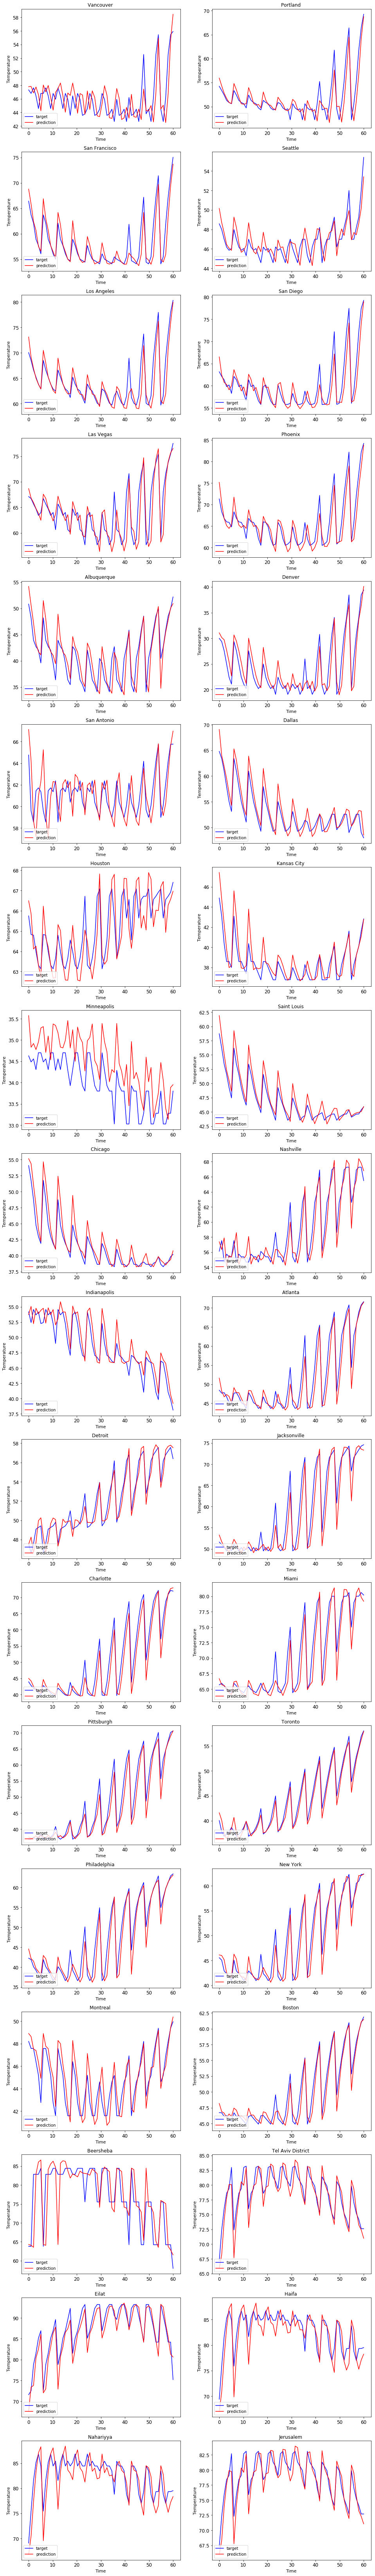

In [12]:
iterations = (int)(batch_size / city_cnt)
sequence_pred = np.empty([city_cnt, n_inputs, iterations, n_steps])
sequence_test = np.empty([city_cnt, n_inputs, iterations, n_steps])
print('sequence_test ', sequence_test.shape)

def plot_predictions(sequence_test, sequence_pred):
    
    plt.rcParams["figure.figsize"] = [16, 120]
    f, ax = plt.subplots(18, 2, sharex = False, sharey = False)
    
       
    for i in range(36):
        p_sequence = sequence_pred[i].flatten()
        t_sequence = sequence_test[i].flatten()
        
        t_instance = np.linspace(0, len(t_sequence), len(t_sequence)).reshape(-1, 1)
        row = (int)(i / 2)
        col = (int)(i % 2)

        axes = ax[row][col]
        str = "%s " % (Columns[i])
        
        axes.set_title(str, fontsize=12)


        axes.plot(t_instance, t_sequence, "b", markersize=10, label="target")
        axes.plot(t_instance, p_sequence, "r", markersize=10, label="prediction")

        axes.legend(loc="lower left")
        axes.set_xlabel("Time", fontsize=11)
        axes.set_ylabel("Temperature", fontsize=11)
    plt.show()
print(y_test_scaled.shape, batch_size)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled.reshape(batch_size, n_steps)).reshape(batch_size, n_steps, 1)
y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled.reshape(batch_size, n_steps)).reshape(batch_size, n_steps, 1)

print(y_pred_unscaled.shape)
print(y_test_unscaled.shape)


for s in range(batch_size):
    city = (int)(s%city_cnt)
    index = (int)(s/city_cnt)
    for col in range(n_inputs):
        sequence_test[city][col][index] = y_test_unscaled[s].T[col]
        sequence_pred[city][col][index] = y_pred_unscaled[s].T[col]

print(sequence_test.shape)
plot_predictions(sequence_test, sequence_pred)    